In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

Model details found [here](https://covid-measures.github.io/). Schematic for the model:

<img src="../images/model_schematic.png" alt="Drawing" style="width: 600px;"/>

In [2]:
# Parameters for the problem ###############################################

pars = [0.5, 0.192, 0.33, 0.5,   0.1428, 0.1736, 0.1428, 0.956, 0.068, 0.2 ]
     # [beta,gamma,alpha,lambdaP,lambdaA,lambdaS,lambdaM,  mu,  rho,  delta]

Cpars= [1, 0.66, 1, 1]
     # [Cp, Ca, Cs, Cm]

pops = [1000,  0 ,  0 ,  0 ,  0 ,  0 , 0 ,  0 , 10000]
     # [ E0,  IP0, IA0, IS0, IM0, IH0, R0,  D0,  N]
     

In [28]:
def num_soln(pars,Cpars,pops):
    
    # N is the total population
    
    # Input parameters ####################
    
    E0  = pops[0]        # floats; Initial number of infected, exposed, and recovered individuals
    IP0 = pops[1]
    IA0 = pops[2]
    IS0 = pops[3]
    IM0 = pops[4]
    H0  = pops[5]
    R0  = pops[6]
    D0  = pops[7]
    N   = pops[8]
    
    S0 = N - IP0 - IA0 - IS0 - IM0 - H0 - D0 - R0 - E0        # float; Everyone else, S0, is susceptible to infection initially.
    
    # Parameters of the problem ############
    
    beta    = pars[0]
    gamma   = pars[1]
    alpha   = pars[2]
    lambdaP = pars[3]
    lambdaA = pars[4]
    lambdaS = pars[5]
    lambdaM = pars[6]
    mu      = pars[7]
    rho     = pars[8]
    delta   = pars[9]
    
    # Contact Parameters ###################
    
    Cp = Cpars[0]
    Ca = Cpars[1]
    Cs = Cpars[2]
    Cm = Cpars[3]
    
    t = np.linspace(0, T_max, 10*T_max)# A grid of time points (in days)
    
    #########################################

    # The differential equations ############
    
    def deriv(y, t):
        S, E, IP, IA, IS, IM, H, R, D = y
        dSdt = -beta * S * (Cp*IP + Ca*IA + Cs*IS + Cm*IM) / N
        dEdt = +beta * S * (Cp*IP + Ca*IA + Cs*IS + Cm*IM) / N - gamma * E
        dIPdt= (1-alpha) * gamma * E  - lambdaP * IP
        dIAdt= alpha * gamma * E - lambdaA*IA
        dISdt= (1-mu) * lambdaP * IP - lambdaS * IS
        dIMdt=  mu * lambdaP * IP - lambdaM * IM
        dHdt = +lambdaS * IS - rho * H
        dRdt = lambdaM * IM + lambdaA * IA + (1-delta) * rho * H
        dDdt = delta * rho * H
        return dSdt, dEdt, dIPdt, dIAdt, dISdt, dIMdt, dHdt, dRdt, dDdt
    
    #########################################
    
    
    y0 = S0, E0, IP0, IA0, IS0, IM0, H0, R0, D0                               # Initial conditions vector
    
    ret = odeint(deriv, y0, t) # Integrate the SIR equations over the time grid, t.
    
    S, E, IP, IA, IS, IM, H, R, D = ret.T                                   # Return the transpose of the matrix

    return t, S/N, E/N, IP/N, IA/N, IS/N, IM/N, H/N, R/N, D/N

<IPython.core.display.Javascript object>


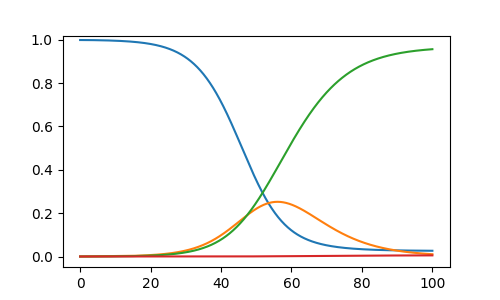

interactive(children=(IntSlider(value=1, description='E_0', max=1000, min=1), IntSlider(value=1000, descriptio…

In [45]:
# Attempt at an interactive graph ###################################

T_max = 100
t, S, E, IP, IA, IS, IM, H, R, D = num_soln(pars,Cpars,pops)

%matplotlib notebook
from ipywidgets import *

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)
line1, = ax.plot(t,S, label='Susc')
line2, = ax.plot(t,IP+IA+IS+IM, label='Inf')
line3, = ax.plot(t,R, label='Rec')
line4, = ax.plot(t,D, label='Dead')

Eslider = IntSlider(min=1,max=1000)
Nslider = IntSlider(min=1000,max=10000)

def update(E_0 = Eslider, N=Nslider):
    pops[0] = E_0
    pops[8] = N
    t, S, E, IP, IA, IS, IM, H, R, D = num_soln(pars,Cpars,pops)
    line1.set_xdata(t)
    line1.set_ydata(S)
    
    line2.set_xdata(t)
    line2.set_ydata(IP+IA+IS+IM+H)
    
    line3.set_xdata(t)
    line3.set_ydata(R)
    
    line4.set_xdata(t)
    line4.set_ydata(D)
    
    fig.canvas.draw_idle()

interact(update);


In [66]:
T_max = 15
import random

def Gillespie(pars,Cpars,pops):
    # Input parameters ####################
    
    n_E  = pops[0]        # floats; Initial number of infected, exposed, and recovered individuals
    n_IP = pops[1]
    n_IA = pops[2]
    n_IS = pops[3]
    n_IM = pops[4]
    n_H  = pops[5]
    n_R  = pops[6]
    n_D  = pops[7]
    N    = pops[8]
    
    n_S = N - n_E - n_IP - n_IA - n_IS - n_IM - n_H - n_D - n_R        # float; Everyone else, n_S, is susceptible to infection initially.
    
    # Parameters of the problem ############
    
    beta    = pars[0]
    gamma   = pars[1]
    alpha   = pars[2]
    lambdaP = pars[3]
    lambdaA = pars[4]
    lambdaS = pars[5]
    lambdaM = pars[6]
    mu      = pars[7]
    rho     = pars[8]
    delta   = pars[9]
    
    # Contact Parameters ###################
    
    Cp = Cpars[0]
    Ca = Cpars[1]
    Cs = Cpars[2]
    Cm = Cpars[3]
    
    #########################################
    
    T = T_max      # float; maximum elapsed time
    _t = 0.0       # float; start time


    V = N          # float; spatial parameter
    
    #########################################


    n_S = N - n_E - n_IP - n_IA - n_IS - n_IM - n_H - n_R - n_D  # Computing susceptible population


    # Initialize results list ###############

    S  = []
    E  = []
    IP = []
    IA = []
    IS = []
    IM = []
    H  = []
    R  = []
    D  = []
    t  = []

    S.append(n_S)
    E.append(n_E)
    IP.append(n_IP)
    IA.append(n_IA)
    IS.append(n_IS)
    IM.append(n_IM)
    H.append(n_H)
    R.append(n_R)
    D.append(n_D)
    t.append(_t)

    #########################################


    # Loop to compute results at every time-step

    while _t < T:                                        
        if  n_E + n_IP + n_IA + n_IS + n_IM == 0:     # <+++ CHECK THIS!       
            break                                     # Stop the loop if there are no infected individuals

        w1 = beta * n_S * (Cp*n_IP + Ca*n_IA + Cs*n_IS + Cm*n_IM) / V
        w2 = (1 - alpha) * gamma * n_E
        w3 = alpha * gamma * n_E
        w4 = (1 - mu) * lambdaP * n_IP
        w5 = mu * lambdaP * n_IP
        w6 = lambdaA * n_IA
        w7 = lambdaS * n_IS
        w8 = lambdaM * n_IM
        w9 = (1 - delta) * rho * n_H
        w10= delta * rho * n_H
        
        
        W = w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10

        dt = -np.log(random.uniform(0.0, 1.0)) / W
        _t = _t + dt
        
        r = random.uniform(0.0, 1.0)
        
        if r < w1 / W:
            n_S = n_S - 1
            n_E = n_E + 1
        elif r < (w1+w2) / W:
            n_E  = n_E - 1
            n_IP = n_IP + 1
        elif r < (w1+w2+w3) / W:
            n_E   = n_E - 1
            n_IA  = n_IA + 1
        elif r < (w1+w2+w3+w4) / W:
            n_IP = n_IP - 1 
            n_IS = n_IS + 1
        elif r < (w1+w2+w3+w4+w5) / W:
            n_IP = n_IP - 1
            n_IM = n_IM + 1
        elif r < (w1+w2+w3+w4+w5+w6) / W:
            n_IA = n_IA - 1
            n_R  = n_R + 1
        elif r < (w1+w2+w3+w4+w5+w6+w7) / W:
            n_IS = n_IS - 1
            n_H  = n_H + 1
        elif r < (w1+w2+w3+w4+w5+w6+w7+w8) / W:
            n_IM = n_IM - 1
            n_R  = n_R + 1
        elif r < (w1+w2+w3+w4+w5+w6+w7+w8+w9) / W:
            n_H  = n_H - 1
            n_R  = n_R + 1
        else:
            n_H = n_H - 1
            n_D = n_D + 1

        S.append(n_S)
        E.append(n_E)
        IP.append(n_IP)
        IA.append(n_IA)
        IS.append(n_IS)
        IM.append(n_IM)
        H.append(n_H)
        R.append(n_R)
        D.append(n_D)
        t.append(_t)

    return t,np.array(S)/N,np.array(E)/N,np.array(IP)/N,np.array(IA)/N,np.array(IS)/N,np.array(IM)/N,np.array(H)/N,np.array(R)/N, np.array(D)/N

### Averaging out Gillespie and comparing it to numerical results

In [131]:
total_iter = 100

T_max = 80
t_av = np.linspace(0.00000001,T_max,T_max)
S_av = np.zeros(len(t_av),float)
E_av = np.zeros(len(t_av),float)
Ip_av = np.zeros(len(t_av),float)
Ia_av = np.zeros(len(t_av),float)
Is_av = np.zeros(len(t_av),float)
Im_av = np.zeros(len(t_av),float)
Ih_av = np.zeros(len(t_av),float)
R_av = np.zeros(len(t_av),float)
D_av = np.zeros(len(t_av),float)

N_tot = 10000
exp_0 = 1000

len_t = []

pops[0] = exp_0
pops[8] = N_tot

for i in range(0,total_iter):
    t,S, E, IP, IA, IS, IM, IH, R, D = Gillespie(pars,Cpars,pops)
    len_t.append(len(t))
    k=0
    j_max = 0
    
    s_at_k = 0
    e_at_k = 0
    ip_at_k = 0
    ia_at_k = 0
    is_at_k = 0
    im_at_k = 0
    ih_at_k = 0
    r_at_k = 0
    d_at_k = 0
    
    while(k<len(t_av)):
        counter = 0
        s_at_k = 0
        e_at_k = 0
        ip_at_k = 0
        ia_at_k = 0
        is_at_k = 0
        im_at_k = 0
        ih_at_k = 0
        r_at_k = 0
        d_at_k = 0
        
        for j in range(j_max,len(t)):
            if(t[j]<t_av[k]):
                s_at_k = s_at_k + S[j]
                e_at_k = e_at_k + E[j]
                ip_at_k = ip_at_k+IP[j]
                ia_at_k = ia_at_k+IA[j]
                is_at_k = is_at_k+IS[j]
                im_at_k = im_at_k+IM[j]
                ih_at_k = ih_at_k+IH[j]
                r_at_k = r_at_k + R[j]
                d_at_k = d_at_k + D[j]
                
                
                counter += 1
            else:
                j_max = j+1
                if(counter !=0):
                    
                    S_av[k] = S_av[k]+s_at_k/counter
                    E_av[k] = E_av[k]+e_at_k/counter
                    Ip_av[k] = Ip_av[k]+ip_at_k/counter
                    Ia_av[k] = Ia_av[k]+ia_at_k/counter
                    Is_av[k] = Is_av[k]+is_at_k/counter
                    Im_av[k] = Im_av[k]+im_at_k/counter
                    Ih_av[k] = Ih_av[k]+ih_at_k/counter
                    R_av[k] = R_av[k]+r_at_k/counter
                    D_av[k] = D_av[k]+d_at_k/counter
                break
        k=k+1
    
    
t_ex, S_ex, E_ex, IP_ex, IA_ex, IS_ex, IM_ex, IH_ex, R_ex, D_ex = num_soln(pars,Cpars,pops)

plt.plot(t_ex,E_ex, linewidth=3, color='red')
plt.plot(t_av,E_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
#plt.savefig('../images/Gillespie_100avg_i0_100_3.png')
plt.show()


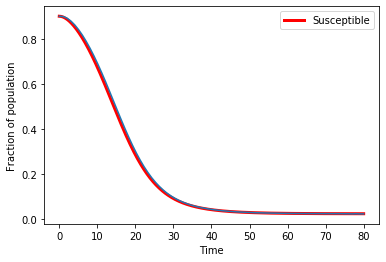

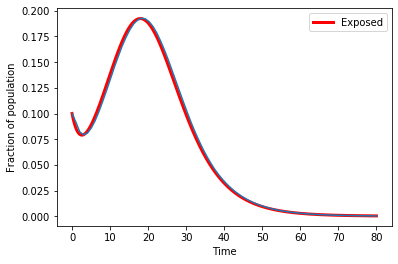

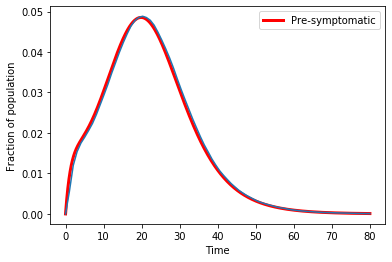

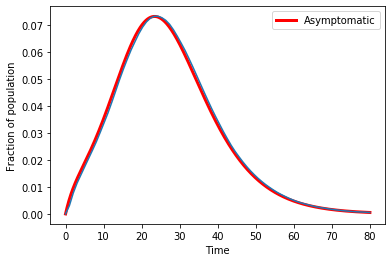

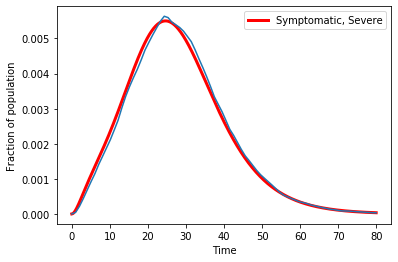

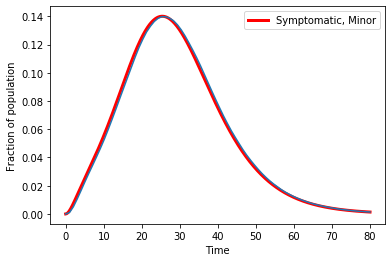

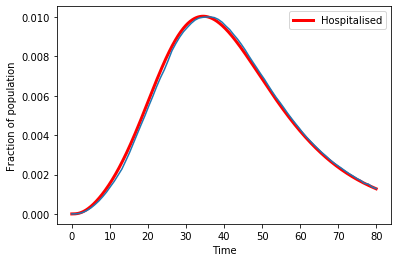

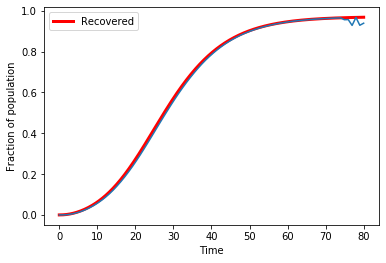

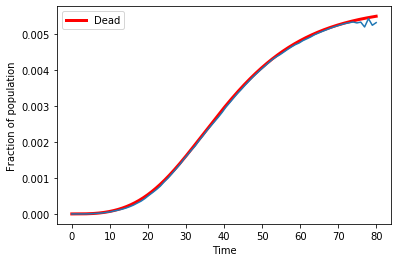

In [132]:
%matplotlib inline
plt.plot(t_ex,S_ex, linewidth=3, color='red',label='Susceptible')
plt.plot(t_av,S_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_100avg_N10000_E01000_Susceptible.png')
plt.show()

plt.plot(t_ex,E_ex, linewidth=3, color='red', label='Exposed')
plt.plot(t_av,E_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_100avg_N10000_E01000_Exposed.png')
plt.show()

plt.plot(t_ex,IP_ex, linewidth=3, color='red', label='Pre-symptomatic')
plt.plot(t_av,Ip_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_100avg_N10000_E01000_Pre-symptomatic.png')
plt.show()

plt.plot(t_ex,IA_ex, linewidth=3, color='red',label='Asymptomatic')
plt.plot(t_av,Ia_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_100avg_N10000_E01000_Asymptomatic.png')
plt.show()

plt.plot(t_ex,IS_ex, linewidth=3, color='red',label='Symptomatic, Severe')
plt.plot(t_av,Is_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_100avg_N10000_E01000_Symptomatic_Severe.png')
plt.show()

plt.plot(t_ex,IM_ex, linewidth=3, color='red',label='Symptomatic, Minor')
plt.plot(t_av,Im_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_100avg_N10000_E01000_Symptomatic_Minor.png')
plt.show()

plt.plot(t_ex,IH_ex, linewidth=3, color='red',label='Hospitalised')
plt.plot(t_av,Ih_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_100avg_N10000_E01000_Hospitalised.png')
plt.show()

plt.plot(t_ex,R_ex, linewidth=3, color='red',label='Recovered')
plt.plot(t_av,R_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_100avg_N10000_E01000_Recovered.png')
plt.show()

plt.plot(t_ex,D_ex, linewidth=3, color='red',label='Dead')
plt.plot(t_av,D_av/total_iter)

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_100avg_N10000_E01000_Dead.png')
plt.show()



<IPython.core.display.Javascript object>


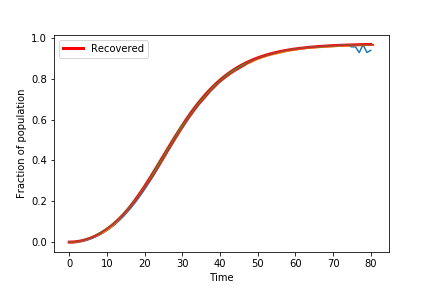

80
34890 80.7642550801175
35102 80.1317098105421
35121 80.66890270239034


In [133]:
# Testing Cell #################################################

%matplotlib notebook
plt.plot(t_ex,R_ex, linewidth=3, color='red',label='Recovered')
plt.plot(t_av,R_av/total_iter)
print(len(t_av))
t,S, E, IP, IA, IS, IM, IH, R, D = Gillespie(pars,Cpars,pops)
#plt.plot(t,S+E+IP+IA+IS+IM+R+IH+D)
plt.plot(t,R)
print(len(t),t[-1])
t,S, E, IP, IA, IS, IM, IH, R, D = Gillespie(pars,Cpars,pops)
#plt.plot(t,S+E+IP+IA+IS+IM+R+IH+D)
plt.plot(t,R)
print(len(t),t[-1])
t,S, E, IP, IA, IS, IM, IH, R, D = Gillespie(pars,Cpars,pops)
#plt.plot(t,S+E+IP+IA+IS+IM+R+IH+D)
plt.plot(t,R)
print(len(t),t[-1])

plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.savefig('../images/Model_singleIterations_N10000_E01000_Recovered.png')
plt.show()